In [1]:
import numpy as np
import pandas as pd

In [2]:
training_data = np.load(f'../fashion_train.npy')
test_data = np.load(f'../fashion_test.npy')

In [3]:
df = pd.DataFrame(training_data)
dftest = pd.DataFrame(test_data)


### Create subset for fast testing

In [4]:
# Split data: x% sample
test_data_trans = dftest.sample(frac=0.1, random_state=1)


### Decision tree (Needs water)

In [5]:
import numpy as np

def find_best_split(data):
    current_min = 2  # Gini ranges from 0 to 1; initialize with a high value.
    split_info = None    
    best_right_count=None
    best_left_count=None

    n = len(data)

    for column in data.columns[:-1]:
        # Sort data by the column for efficient split calculations
        sorted_data = data.sort_values(by=column)
        values = sorted_data[column].values
        labels = sorted_data[data.columns[-1]].values

        # Initialize running totals for calculating Gini efficiently
        left_counts = np.zeros(5, dtype=int)
        right_counts = np.bincount(labels, minlength=5).astype(int)
        total_right = len(labels)

        for i in range(len(values) - 1):
            label = labels[i]
            left_counts[label] += 1
            right_counts[label] -= 1
            total_left = i + 1
            total_right -= 1

            # Only consider unique values for splits
            if values[i] == values[i + 1]:
                continue

            gini_left = 1.0 - np.sum((left_counts / total_left) ** 2)
            gini_right = 1.0 - np.sum((right_counts / total_right) ** 2)
            weighted_gini = (gini_left * total_left + gini_right * total_right) / n

            if weighted_gini < current_min:       
                current_min = weighted_gini
                split_info = [current_min, column, values[i]]
                best_right_count=right_counts.copy()
                best_left_count=left_counts.copy()

    return split_info, [best_left_count,best_right_count]


In [6]:
rep=0
k = 10
splits = {i: [] for i in range(k)}

def split_data(data,level):
    global rep
    rep+=1
    if rep%10==0:
        print( "rep: " + str(rep))
        
    if  isinstance(data, str) and data == "deadleaf": #leaf detection
      splits[level].append(("deadleaf")) 
      if level + 1 < k:
            split_data("deadleaf", level + 1)
            split_data("deadleaf", level + 1)

    elif data.iloc[:, -1].nunique() == 1: #leaf detection
      majority=(data[data.columns[-1]].mode().iloc[0])
      splits[level].append(("leaf",majority)) 
      if level + 1 < k:
            split_data("deadleaf", level + 1)
            split_data("deadleaf", level + 1)

    else:
      result=find_best_split(data)
      gini,column,value=result[0]
      left_majority,right_majority=result[1]
      df1 = data[data[column] > value]
      df2 = data[data[column] <= value]
      # Update splits dictionary
      splits[level].append((gini,column,value,left_majority,right_majority))
      #splits[level].append((len(data), split_index))
      # Recursive splitting until level reaches `k`
      #print(gini)
      if level + 1 < k:
          split_data(df2, level + 1)
          split_data(df1, level + 1)


split_data(df,0)


rep: 10
rep: 20
rep: 30
rep: 40
rep: 50
rep: 60
rep: 70
rep: 80
rep: 90
rep: 100
rep: 110
rep: 120
rep: 130
rep: 140
rep: 150
rep: 160
rep: 170
rep: 180
rep: 190
rep: 200
rep: 210
rep: 220
rep: 230
rep: 240
rep: 250
rep: 260
rep: 270
rep: 280
rep: 290
rep: 300
rep: 310
rep: 320
rep: 330
rep: 340
rep: 350
rep: 360
rep: 370
rep: 380
rep: 390
rep: 400
rep: 410
rep: 420
rep: 430
rep: 440
rep: 450
rep: 460
rep: 470
rep: 480
rep: 490
rep: 500
rep: 510
rep: 520
rep: 530
rep: 540
rep: 550
rep: 560
rep: 570
rep: 580
rep: 590
rep: 600
rep: 610
rep: 620
rep: 630
rep: 640
rep: 650
rep: 660
rep: 670
rep: 680
rep: 690
rep: 700
rep: 710
rep: 720
rep: 730
rep: 740
rep: 750
rep: 760
rep: 770
rep: 780
rep: 790
rep: 800
rep: 810
rep: 820
rep: 830
rep: 840
rep: 850
rep: 860
rep: 870
rep: 880
rep: 890
rep: 900
rep: 910
rep: 920
rep: 930
rep: 940
rep: 950
rep: 960
rep: 970
rep: 980
rep: 990
rep: 1000
rep: 1010
rep: 1020


In [ ]:
# for i in splits:
#     print(splits[i])


In [8]:
def predict(row,max_depth=100):
    lastcheck=0
    depth=min(max_depth,len(splits)-1)
    currentclass=None
    weight=np.array([1,1,1,1,1])
    for i in range(depth):
        #print(lastcheck)
        if splits[i][lastcheck][0]=="leaf":
            return currentclass#splits[i][lastcheck][1]
    
        if splits[i][lastcheck]=="deadleaf":
            print("error unreachable node reached")

        elif row[splits[i][lastcheck][1]] <= splits[i][lastcheck][2]:
            classes=splits[i][lastcheck][3]*weight
            max_indices = np.where(classes == np.max(classes))[0]
            currentclass = np.random.choice(max_indices)
            # if sum(classes)<=5: #minimum node test
            #     return currentclass
            #print(currentclass)
            lastcheck=2*lastcheck

        else:
            classes=splits[i][lastcheck][4]*weight
            max_indices = np.where(classes == np.max(classes))[0]
            currentclass = np.random.choice(max_indices)
            # if sum(classes)<=10: #minimum node test
            #     return currentclass
            # print(currentclass)
            lastcheck=2*lastcheck+1
            
   # print("we did it")        
    return currentclass

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score

print("test data")
# Generate predictions, passing each row in test_data_trans to predict
predictions = []
for k in range(dftest.shape[0]):
    predictions.append(predict(list(dftest.iloc[k]),10)) 
# Assuming the last element in each row is the true label
true_labels  = list(dftest.iloc[:, -1])
#predictions = [1 if x == 0 else x for x in predictions]
print(predictions)
print(true_labels)

# Calculate the confusion matrix and accuracy
conf_matrix = confusion_matrix(true_labels, predictions)
accuracy = accuracy_score(true_labels, predictions)

print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy * 100:.2f}%")



test data
[1, 0, 3, 0, 3, 0, 0, 0, 3, 3, 1, 0, 3, 1, 2, 0, 3, 3, 2, 1, 1, 3, 3, 0, 0, 4, 0, 3, 2, 3, 1, 0, 3, 4, 1, 0, 4, 1, 3, 1, 0, 0, 3, 4, 1, 0, 1, 3, 3, 0, 2, 2, 2, 0, 0, 2, 1, 2, 4, 1, 3, 2, 0, 1, 3, 2, 0, 4, 0, 3, 1, 4, 4, 0, 3, 2, 1, 0, 3, 1, 3, 4, 4, 1, 2, 1, 3, 1, 3, 3, 0, 1, 4, 4, 3, 3, 3, 0, 3, 0, 1, 4, 1, 0, 4, 0, 0, 1, 3, 0, 1, 1, 2, 4, 3, 1, 1, 1, 0, 2, 3, 0, 2, 3, 0, 1, 4, 4, 2, 2, 2, 1, 2, 4, 4, 0, 2, 4, 2, 2, 4, 0, 3, 3, 1, 1, 3, 2, 3, 2, 1, 2, 2, 4, 2, 3, 3, 2, 1, 3, 2, 4, 3, 4, 4, 0, 4, 1, 3, 3, 1, 1, 4, 1, 4, 2, 4, 2, 3, 4, 4, 2, 0, 2, 2, 2, 0, 3, 1, 0, 0, 2, 0, 4, 2, 3, 4, 4, 4, 1, 1, 4, 4, 4, 2, 3, 0, 2, 1, 0, 4, 0, 1, 4, 1, 4, 2, 1, 0, 2, 3, 2, 3, 4, 1, 0, 2, 2, 3, 0, 0, 0, 1, 4, 1, 0, 2, 2, 0, 1, 0, 2, 4, 3, 4, 3, 0, 3, 4, 1, 4, 1, 0, 2, 2, 3, 2, 0, 1, 4, 3, 2, 3, 2, 0, 0, 3, 3, 2, 1, 2, 1, 0, 3, 3, 1, 3, 4, 4, 3, 3, 0, 4, 1, 2, 2, 3, 2, 2, 2, 2, 4, 2, 4, 0, 2, 4, 3, 1, 0, 2, 4, 0, 3, 0, 4, 4, 0, 2, 1, 4, 0, 3, 1, 3, 2, 2, 0, 0, 2, 4, 1, 1, 4, 4, 4, 2, 2, 1, 0,

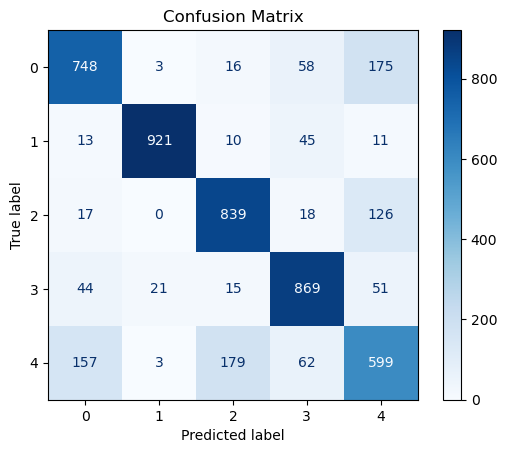

Confusion Matrix:
[[748   3  16  58 175]
 [ 13 921  10  45  11]
 [ 17   0 839  18 126]
 [ 44  21  15 869  51]
 [157   3 179  62 599]]
[0.748, 0.921, 0.839, 0.869, 0.599]
total accueracy 0.7952


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score


# Generate confusion matrix
cm = confusion_matrix(true_labels,predictions)

#Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(5))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Print the confusion matrix for reference
print("Confusion Matrix:")
print(cm)


misclassification_rate=[]

for i in range(5):
    total_row = np.sum(cm[i,:])
    error_rate = cm[i,i] / total_row
    misclassification_rate.append(error_rate)
print(misclassification_rate)

print("total accueracy",accuracy_score(true_labels, predictions))
